In [144]:
#import necessary libraries
import requests
import json
import pandas as pd
import geopandasas gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re
import spotipy
import base64
import teetool as tt

api_key = "fCnCRQ1S6LDAS7zQ"
client_id = 'f5a0fe76389c42c0b85c832f1de66cf7'
client_secret = 'e9d4fc0874f345b2b636a6e307384bb7'

world = gpd.read_file('Countries_WGS84/Countries_WGS84.shp') #open file
states = gpd.read_file('states_21basic/states.shp') #open file

s2 = states[['geometry', 'STATE_ABBR']]
s2.columns = ['geometry', 'name']

w2 = world[['geometry', 'CNTRY_NAME']]
w2.columns = ['geometry', 'name']

ws = w2.append(s2)

print(ws)


#maybe remove festivals - songkick
# maybe market - spotify

                                             geometry                 name
0   POLYGON ((-69.8822326660156 12.4111099243165, ...                Aruba
1   (POLYGON ((-61.7388916015625 17.5405540466309,...  Antigua and Barbuda
2   POLYGON ((61.2765579223633 35.6072463989258, 6...          Afghanistan
3   POLYGON ((-5.15213489532459 30.1804695129396, ...              Algeria
4   (POLYGON ((45.0258293151855 41.0305480957031, ...           Azerbaijan
..                                                ...                  ...
46  POLYGON ((-94.46169128436209 34.19676535931296...                   AR
47  (POLYGON ((-93.70752428365972 30.2395783556275...                   LA
48  (POLYGON ((-80.7856622716253 28.78519435427305...                   FL
49  (POLYGON ((-88.49752727880752 48.1737953723300...                   MI
50  (POLYGON ((-161.3337853466416 58.7332483821643...                   AK

[302 rows x 2 columns]


In [5]:
#spotipy playground
from spotipy.oauth2 import SpotifyClientCredentials

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

playlists = sp.user_playlists('spotify')

"https://api.spotify.com/v1/search?q=year%3A2001&type=artist&market=US"

# se = sp.search(q = 'year:0000-9999', limit = 1, offset = 9999, type = 'artist', market = 'US')

se = sp.search(q = 'tag:hipster ', limit = 1, offset = 5678, type = 'album', market = 'US')

se = sp.search(q = 'berhana', limit = 1, type = 'artist')

In [6]:
# spotify function definitions

# given a name/id or genre, will provide a list of 
# artists that exist in relation and also are within the follower limit

# custom function used to sort by num of shared genres
def custom_sort(x):
    return x[2]

query_count = 0

# handles counting the genres for related artists
def ra_help(artid, genres):
    global query_count
    alist = []
    if query_count < 10:
        for a in sp.artist_related_artists(artid)['artists']:
            gc = 0
            for g in a['genres']:    
                if g in genres:
                    gc += 1
            if gc > 0 and ([item for item in alist if item[1] == a['id']] == []):
                alist.append((a['name'], a['id'], gc))
        return sorted(alist, key = custom_sort, reverse = True)
                    
# used to faciliate recursive calls - 
# allows me to find the related artists in each level of separation from the root
# before moving on to the root artist
def ra_rec(lst, genres, followers, lessthan):
    global query_count
    lst2 = []
    for a in lst:
        if query_count < 10:
            lst2+=(ra_help(a[1], genres))
            query_count += 1
#         print("ra_rec ra_help" + str(query_count))
    if query_count < 10:
        lst2 += (ra_rec((sorted(lst2, key = custom_sort)), genres, followers, lessthan))    
    
    return sorted(lst2, key = custom_sort, reverse = True)

def related_artists(artname='', artid='', genre='', followers=-1, lessthan = True):
    if (artname == '' and artid == '' and genre == ''):
        print('please include name, id, or genre')
        return
    else:
        global query_count
        query_count = 0
        alist = []
        if (artname != ''):
            se = sp.search(q = artname, limit = 1, type = 'artist')
            query_count += 1
            print("related_artists search " + str(query_count))
            if (se['artists']['total'] > 0):
                artist = se['artists']['items'][0]
                artid = artist['id']
                genres = artist['genres']
        elif (artid != ''):
            artist = sp.artist(artid)
            genres = artist['genres']

        lst = ra_help(artid, genres)
#         print(lst)
        query_count += 1
        print("related_artists ra_help " + str(query_count))
                
        if query_count < 10:
            lst+=(ra_rec(lst, genres, followers, lessthan))
          
        print(len(lst))
        
        print(len(sorted(list(set(lst)), key = custom_sort)))
    
    return sorted(list(set(lst)), key = custom_sort, reverse = True) 

# related_artists(artid = '0WjtdWS6su0f3jrW9aqEHl')    

In [45]:
# function definitions
def make_points(json_str, artist):
    df = pd.DataFrame(
    {'Artist': [],
     'Venue': [],
     'City': [],
     'State/Province': [],
     'Country': [],
     'Longitude': [],
     'Latitude': []})

    i = 0
    
    if (json_str['resultsPage']['totalEntries'] != 0):
        for p in json_str['resultsPage']['results']['event']:
            #     print(p['popularity'])
            venue = p['venue']['displayName']
            lng = p['location']['lng']
            lat = p['location']['lat']
            city = p['location']['city']
            state = 'N/A'
            csplit = city.split(',')
            country = csplit[1]
        
            if (len(csplit) == 3):
                if not ('Washington' == csplit[0] and 'DC' == csplit[1]):
                    city = csplit[0]
                    state = csplit[1]
                    country = csplit[2]
                else:
                    city = csplit[0] + ', ' + csplit[1]
                    state = 'N/A'
                    country = csplit[2].replace(' ', '')
        
            df.loc[i] = [artist] + [venue] + [city] + [state] + [country] + [lat] +[lng]

            i+=1
        #convert to gdf to plot
        gdf = gpd.GeoDataFrame(
            df, geometry=[Point(x, y) for y, x in zip(df['Longitude'], df['Latitude'])])

        gdf2 = gdf
        gdf2 = gdf2.drop(list(range(1, len(gdf))))
        gdf3 = gdf
        gdf3 = gdf3.drop(list(range(0, len(gdf)-1)))
    
        return(gdf, gdf2, gdf3)
    else:
        return -1

def run_plot(req, aname):
    gdfs = make_points(req.json(), aname)

    points_gdf = gdfs[0]
    print(points_gdf)
    start_gdf = gdfs[1]
    stop_gdf = gdfs[2]

    #current us basemap
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # fig, ax = plt.subplots(figsize=(15,15))
    ax = world[world.continent == 'North America'].plot(
#     ax = world.plot(
        color='white', edgecolor='black')

    ax.set_xlim(-130, -65)
    ax.set_ylim(24, 50)

    # We can now plot our ``GeoDataFrame``.
    points_gdf.plot(ax=ax, color='blue')

    start_gdf.plot(ax=ax, color='green')
    stop_gdf.plot(ax=ax, color='red')

    points = []

    linedf = pd.DataFrame(
        {'Line': []})

    for i in range(len(points_gdf)):
        points.append(points_gdf.iloc[i].loc["geometry"])

    line = LineString(points)

    def plot_line(ax, ob):
        x, y = ob.xy
        ax.plot(x, y, color='grey', alpha=0.7, linewidth=1, solid_capstyle='round', zorder=2)

    plot_line(ax, line)

    plt.tight_layout()

    plt.show()
    
def get_artist_id(artist_name):
    json_str = requests.get("https://api.songkick.com/api/3.0/search/artists.json?apikey=" + api_key + "&query=" + artist_name).json()
    return (str(json_str['resultsPage']['results']['artist'][0]['id']) if json_str['resultsPage']['totalEntries'] != 0 else -1)

def req_input():
    print("Welcome")
    while (True):
        past = True
        is_venue = True
        
        cmd = input("Venue search (0) or event search (1)?")
        
        if (cmd == 1):
            is_venue = False
            
        if (is_venue == False):
            cmd = input("Past events (0), upcoming events (1): ")
        
            if (cmd == 1):
                past = False
            
            cmd = input("Please type the parameters: [artist_name, min_date, max_date.] Separate with commas."
                       + "\nIf no input, just add a comma and skip.\n")
        
            if (cmd == 'quit'):
                return
        
            cs = cmd.split(',')
            an = get_artist_id(cs[0].replace(' ', '+')) if not (cs[0]+' ').isspace() else print('need artist!')
            if (cs[0]+' ').isspace():
                continue
            mind = "&min_date=" + cs[1].replace(' ', '') if (re.search("\d{4}-\d{2}-\d{2}", cs[1])) else ''
            maxd = "&max_date=" + cs[2].replace(' ', '') if (re.search("\d{4}-\d{2}-\d{2}", cs[2])) else ''
            
            if (past == True):
                r = requests.get("https://api.songkick.com/api/3.0/artists/"+ an +"/gigography.json?apikey="+ api_key 
                              + mind + maxd)
                run_plot(r, cs[0])
            else:
                r = requests.get("https://api.songkick.com/api/3.0/events.json?apikey="+ api_key 
                    + an + loc + mind + maxd)
                print(r.json())
                run_plot(r, cs[0])
        else:
            cmd = input("Past venues (0), upcoming venues (1): ")
        
            if (cmd == 1):
                past = False
            
        cmd = input("Please type the parameters: [artist_name, min_date, max_date.] Separate with commas."
                   + "\nIf no input, just add a comma and skip.\n")
        
        if (cmd == 'quit'):
            return
        
        cs = cmd.split(',')
        an = get_artist_id(cs[0].replace(' ', '+')) if not (cs[0]+' ').isspace() else print('need artist!')
        if (cs[0]+' ').isspace():
            continue
        mind = "&min_date=" + cs[1].replace(' ', '') if (re.search("\d{4}-\d{2}-\d{2}", cs[1])) else ''
        maxd = "&max_date=" + cs[2].replace(' ', '') if (re.search("\d{4}-\d{2}-\d{2}", cs[2])) else ''
        
        if (past == True):
            r = requests.get("https://api.songkick.com/api/3.0/artists/"+ an +"/gigography.json?apikey="+ api_key 
                              + mind + maxd)
            run_plot(r, cs[0])
        else:
            r = requests.get("https://api.songkick.com/api/3.0/events.json?apikey="+ api_key 
                + an + loc + mind + maxd)
            print(r.json())
            run_plot(r, cs[0])
              

    
# req = requests.get("https://api.songkick.com/api/3.0/events.json?apikey=fCnCRQ1S6LDAS7zQ&artist_name=young+thug&min_date=2019-10-01&max_date=2019-11-01")

# req = requests.get("https://api.songkick.com/api/3.0/events.json?apikey=fCnCRQ1S6LDAS7zQ&artist_name=travis+scott&min_date=2018-01-01&max_date=2022-11-01")

# print(get_artist_id('travis+scott'))

# print("https://api.songkick.com/api/3.0/artists/"+ get_artist_id('travis+scott') + "/gigography.json?apikey=fCnCRQ1S6LDAS7zQ")

# print(req.text)
    

In [146]:
# find the last 20 concerts for root artist and related artists - use num of genres as weights
# cluster analysis 
# basic stats - top5 states/venues/countries

# also, autocorrelation function - if us, then do using states, or cenpy for one state. otherwise, countries (in a continent)

# with what i have, can do - cluster analysis, top5 states/countries; need to add venue info, 

def compile_points(name):
    artists = related_artists(artname = name)

    gl = []

    for a in artists:
        an = get_artist_id(a[0].replace(' ', '+')) if not (a[0]+' ').isspace() else print('need artist!')
    
        if an != -1:
            req = requests.get("https://api.songkick.com/api/3.0/artists/"+ an +"/gigography.json?apikey="+ api_key + '&per_page=20&order=desc')
#             print("https://api.songkick.com/api/3.0/artists/"+ an +"/gigography.json?apikey="+ api_key + '&per_page=20&order=desc')
            gdfs = make_points(req.json(), a[0])
            if gdfs != -1:
                gl.append(gdfs[0])
            
    return gl

gdfs = compile_points('aster aweke')


related_artists search 1
related_artists ra_help 2
167
60


In [160]:
x = related_artists(artname = 'aster aweke')

for i in range(5):
    print(x[i])

# print(gdfs)
for i, row in gdfs[0].iterrows():
    if (i >= 5):
        break
    print(row)

related_artists search 1
related_artists ra_help 2
167
60
('Ahmed Teshome', '3J2flo2lkjE5aVRtH9Vhbn', 2)
('Mahmoud Ahmed', '1QrSgIS6RU4dgNPxLQMoha', 2)
('Teddy Afro', '08oMhAUN23C91R1zltrR6p', 2)
('Neway Debebe', '3fFJDUS5LQKqWXwqhqNgSY', 2)
('Ephrem Tamiru', '2R863D7ulLA8AJRllmiW60', 2)
Artist                        Mahmoud Ahmed
Venue                            Pecan Park
City               Lehavot HaBashan, Israel
State/Province                          N/A
Country                              Israel
Longitude                           33.1412
Latitude                            35.6479
geometry          POINT (35.64787 33.14122)
Name: 0, dtype: object
Artist                      Mahmoud Ahmed
Venue                   Théâtre de la Mer
City                         Sete, France
State/Province                        N/A
Country                            France
Longitude                         43.3928
Latitude                          3.68581
geometry          POINT (3.68581 43.3928)


Top 5 venues:
Echostage 5
S.O.B.'s 5
Théâtre de la Mer 2
LA CARTONNERIE 2
Union Transfer 2

Top 5 cities:
Washington, DC 8
Manhattan, NY 5
Philadelphia, PA 3
New York, NY 2
Cambridge, MA 2

Top 5 countries:
US 28
Germany 19
France 18
Indonesia 11
NY 8


<Figure size 720x864 with 0 Axes>

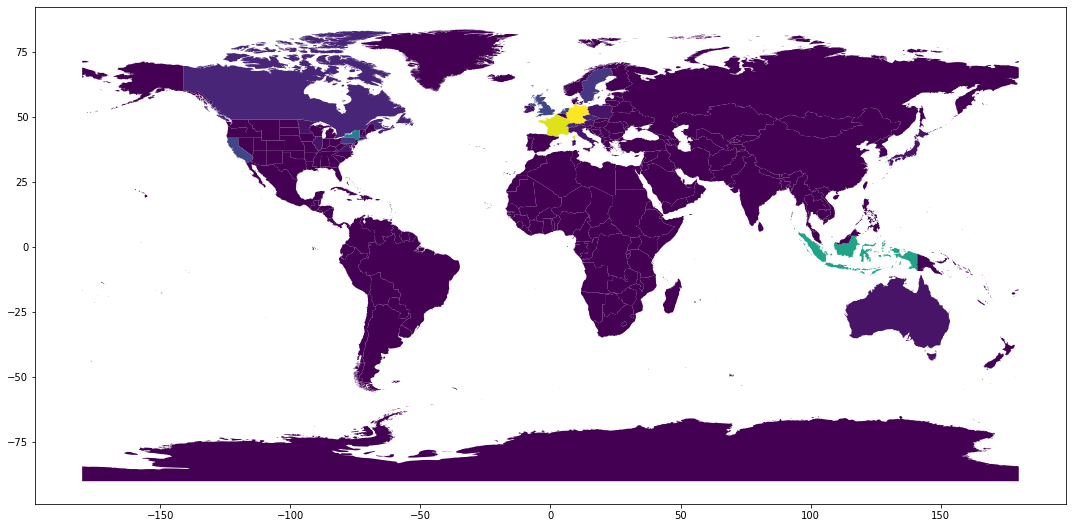

/Users/kalebtsegaye/miniconda3/envs/env1/lib/python3.7/site-packages/libpysal/weights/weights.py:165: UserWarning: The weights matrix is not fully connected: 
 There are 101 disconnected components.
 There are 96 islands with ids: 0, 1, 9, 11, 13, 14, 15, 16, 18, 20, 28, 32, 35, 38, 43, 44, 46, 48, 51, 52, 53, 54, 57, 58, 71, 72, 73, 74, 75, 76, 78, 84, 85, 86, 88, 89, 90, 97, 99, 102, 104, 106, 112, 113, 114, 115, 117, 118, 122, 124, 137, 138, 141, 143, 149, 150, 152, 154, 159, 160, 161, 163, 168, 170, 172, 174, 176, 177, 183, 186, 187, 189, 190, 194, 195, 196, 199, 203, 207, 209, 211, 215, 218, 219, 220, 222, 225, 226, 235, 237, 239, 242, 244, 245, 250, 300.
  warnings.warn(message)


0.22457595626851798, 0.008


/Users/kalebtsegaye/miniconda3/envs/env1/lib/python3.7/site-packages/mapclassify/classifiers.py:95: UserWarning: Warning: Not enough unique values in array to form k classes
  UserWarning)
/Users/kalebtsegaye/miniconda3/envs/env1/lib/python3.7/site-packages/mapclassify/classifiers.py:96: UserWarning: Warning: setting k to 2
  Warn('Warning: setting k to %d' % k_q, UserWarning)


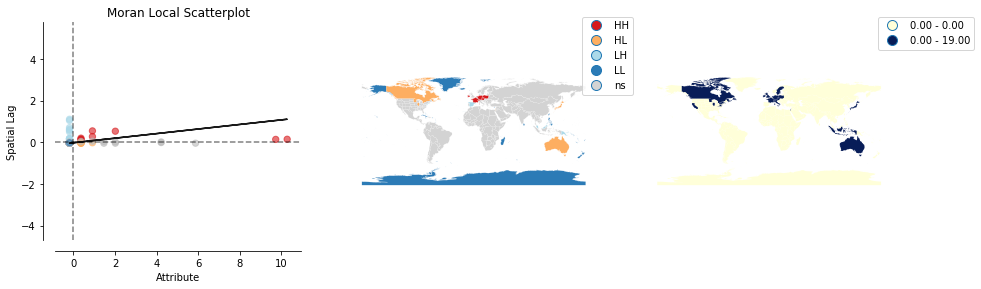

In [161]:
from collections import Counter
import libpysal
from pysal.model import spreg
from libpysal.weights import Queen, Rook, KNN, Kernel
import pysal
from pysal.explore import esda
import cenpy

def analyze(gdfs, state = ''):
    rdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
#     print(rdf)
    
    # basic stats
    venues = {}
    cities = {}
    countries_states = {}
    
    for index, row in rdf.iterrows():
        if row[1] != 'Unknown venue':
            if row[1] not in venues:
                venues[row[1]] = 1
            else:
                venues[row[1]] += 1
          
        if row[3] != 'N/A':
            if (row[2] + ', ' + row[3][1:]) not in cities:
                cities[(row[2] + ', ' + row[3][1:])] = 1
            else:
                cities[(row[2] + ', ' + row[3][1:])] += 1
        else:
            if (row[2] + ', ' + row[4]) not in cities:
                cities[(row[2] + ', ' + row[4][1:])] = 1
            else:
                cities[(row[2] + ', ' + row[4][1:])] += 1
            
        if row[3] != 'N/A':
            if (row[3][1:]) not in countries_states:
                countries_states[row[3][1:]] = 1
            else:
                countries_states[row[3][1:]] += 1

        
        if (row[4][1:]) not in countries_states:
            countries_states[row[4][1:]] = 1
        else:
            countries_states[row[4][1:]] += 1
        
#         print(row)
    
    print('Top 5 venues:')
    top = Counter(venues)
    for i in top.most_common(5):
        print(i[0] + ' ' + str(i[1]))
        
    print('\nTop 5 cities:')
    top = Counter(cities)
    for i in top.most_common(5):
        print(i[0] + ' ' + str(i[1]))
        
    print('\nTop 5 countries:')
    top = Counter(countries_states)
    for i in top.most_common(5):
        print(i[0] + ' ' + str(i[1]))
        
    # end basic stats
    
    # 
    
    plt.figure(figsize=(10, 12))

    world = gpd.read_file('Countries_WGS84/Countries_WGS84.shp') #open file
    
    showcount = []
    
    for index, row in ws.iterrows():
        if row[1] == 'United States':
            c = 'US'            
        elif row[1] == 'United Kingdom':
            c = 'UK'
        else:
            c = row[1]
#             print(c)
        
        if c in countries_states:
            showcount.append(countries_states[c])
        else:
            showcount.append(0)
        
    ws["ShowCount"] = showcount #make new column

    for index, row in ws.iterrows():
        if row[1] == 'United States':
            ws.drop(index, inplace=True)
    
    fig, ax = plt.subplots(figsize=(15,15)) #plot
    ws.plot("ShowCount", ax=ax)
    plt.tight_layout()
    plt.show()
    
    # morans i

    qW = Queen.from_dataframe(ws)
    
    qW.silent_island_warning = True

    qW.transform = 'r'

    #moran
    moran_sc = esda.moran.Moran(ws[['ShowCount']], qW)

    #lisa
    lisa_sc = esda.Moran_Local(ws["ShowCount"], qW)

    print(str(moran_sc.I) + ", " + str(moran_sc.p_sim))
    
    from pysal.viz.splot import esda as esdaplot
    esdaplot.plot_local_autocorrelation(lisa_sc, ws, "ShowCount")
    
#     if state in countries_states:
#         state_cen = cenpy.products.Decennial2010().from_state(state)

#         state_gdf = rdf
#         for index, row in state_gdf.iterrows():
#             i


        
#     ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fontsize = 2)

#     rdf.plot(ax=ax, color='red', markersize = 2.0)

    plt.show()

analyze(gdfs)

In [118]:
import cenpy

md = cenpy.products.Decennial2010().from_state('Maryland')

In [137]:
md2 = cenpy.products.Decennial2010().from_state('California', level = 'county')

In [138]:
state_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

print(state_gdf)
for index, row in state_gdf.iterrows():
    if row[3][1:] != 'CA':
        state_gdf.drop(index, inplace=True)
print(state_gdf)
      
dfsjoin = gpd.sjoin(md2,state_gdf) #Spatial join Points to polygons
# dfpivot = pd.pivot_table(dfsjoin,index='geometry',columns='Food',aggfunc={'Food':len})
# dfpivot.columns = dfpivot.columns.droplevel()

print(dfsjoin)
# dfpolynew = polys.merge(dfpivot, how='left',on='PolyID')

             Artist               Venue                City State/Province  \
0        Disclosure           The Depot      Manchester, UK            N/A   
1        Disclosure         Park Slaski     Chorzów, Poland            N/A   
2        Disclosure         Park Slaski     Chorzów, Poland            N/A   
3        Disclosure  Positivus Festival  Salacgriva, Latvia            N/A   
4        Disclosure       Unknown venue    Lisbon, Portugal            N/A   
...             ...                 ...                 ...            ...   
1147  Friend Within   Revolver Upstairs           Melbourne            VIC   
1148  Friend Within             Stealth      Nottingham, UK            N/A   
1149  Friend Within   Lowther Deer Park         Penrith, UK            N/A   
1150  Friend Within             Stealth      Nottingham, UK            N/A   
1151  Friend Within              fabric          London, UK            N/A   

         Country  Longitude    Latitude                        

In [98]:
req_input()

#travis scott, 2018-10-31, 2018-12-01

Welcome


KeyboardInterrupt: 

In [99]:
re.search("\d{4}-\d{2}-\d{2}", "2018-12-01")

<re.Match object; span=(0, 10), match='2018-12-01'>

In [256]:
points = []
# points.__array_interface__ = 

linedf = pd.DataFrame(
    {'Line': []})

for i in range(len(gdf)):
    points.append(gdf.iloc[i].loc["geometry"])
#     lon1 = gdf.iloc[i].loc["Longitude"]
#     lon2 = gdf.iloc[i+1].loc["Longitude"]
#     lat1 = gdf.iloc[i].loc["Latitude"]
#     lat2 = gdf.iloc[i+1].loc["Latitude"]


# linegdf = gpd.GeoDataFrame(
#         df, geometry=[Point(x, y) for y, x in zip(df['Longitude'], df['Latitude'])])


line = LineString(points)
# linedf.iloc[0] = 

# linegdf = gpd.GeoDataFrame(line, geometry=[Point(x, y) for y, x in zip(df['Longitude'], df['Latitude'])])

# line.plot(ax=ax, color='blue')

# line.plot_coords()

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    
plot_line(ax, line)

plt.show()


